In [1]:
import sys
print(sys.version)
print(sys.path)

3.6.12 (default, Dec 20 2020, 10:59:16) 
[GCC Apple LLVM 12.0.0 (clang-1200.0.32.28)]
['/Users/tokudo/.pyenv/versions/3.6.12/lib/python36.zip', '/Users/tokudo/.pyenv/versions/3.6.12/lib/python3.6', '/Users/tokudo/.pyenv/versions/3.6.12/lib/python3.6/lib-dynload', '', '/Users/tokudo/Develop/grips/venv/lib/python3.6/site-packages', '/Users/tokudo/Develop/grips/grina', '/Users/tokudo/Develop/grips/venv/lib/python3.6/site-packages/IPython/extensions', '/Users/tokudo/.ipython']


In [2]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import grina
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
fpath = os.path.join("..", "data", "unicorn_company_invester.csv")
df = pd.read_csv(fpath, converters={"Select Investors": lambda x: x.split(",")})

In [4]:
def trans2float(x):
    y = x[1:]
    return float(y)

df["Valuation($B) flaot"] = df["Valuation($B)"].apply(trans2float)

In [5]:
df["Valuation($B) flaot"].describe()

count    501.000000
mean       3.185749
std        7.676841
min        1.000000
25%        1.000000
50%        1.500000
75%        3.000000
max      140.000000
Name: Valuation($B) flaot, dtype: float64

In [6]:
df["DateTime Joined"] = df["Date Joined"].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

In [7]:
df.head()

,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
0,100credit,$1,4/18/2018,China,Fintech,"[Sequoia Capital China, China Reform Fund, H...",1.0,2018-04-18
1,17zuoye,$1,3/7/2018,China,Edtech,"[DST Global, Temasek Holdings]",1.0,2018-03-07
2,23andMe,$2.50,7/3/2015,United States,Health,"[Google Ventures, New Enterprise Associates, ...",2.5,2015-07-03
3,4Paradigm,$2,12/19/2018,China,Artificial intelligence,"[Sequoia Capital China, China Construction Ba...",2.0,2018-12-19
4,58 Daojia,$1,10/12/2015,China,Internet software & services,"[KKR, Alibaba Group, Ping An Insurance]",1.0,2015-10-12


In [8]:
def clean(element):
    return element.strip()

In [9]:
r_comps, r_invests = [], []
for company, investors in df[["Company", "Select Investors"]].values.tolist():
    n_rows = len(investors)
    comps = np.full(n_rows, company)
    r_comps += comps.tolist()
    r_invests += investors
r_comps = list(map(clean, r_comps))
r_invests = list(map(clean, r_invests))

In [10]:
# Unicornで投資を行っている企業が存在するため、2部グラフにするためにInvester&Unicornの場合はInvester名に"_"を追加
for i, invest in enumerate(r_invests):
    if invest in r_comps:
        print(invest)
        r_invests[i] = invest + "_"

Didi Chuxing
Bitmain Technologies
Grab
Tokopedia


In [11]:
rdf = pd.DataFrame()
rdf["Company"] = np.array(r_comps)
rdf["Investors"] = np.array(r_invests)
rdf

,Company,Investors
0,100credit,Sequoia Capital China
1,100credit,China Reform Fund
2,100credit,Hillhouse Capital Management
3,17zuoye,DST Global
4,17zuoye,Temasek Holdings
...,...,...
1380,Zwift,True
1381,Zwift,Causeway Media Partners
1382,Zymergen,Data Collective
1383,Zymergen,True Ventures


In [12]:
B = nx.Graph()

In [13]:
B.add_nodes_from(rdf["Company"].unique().tolist(), bipartite=0)
B.add_nodes_from(rdf["Investors"].unique().tolist(), bipartite=1)

In [14]:
edges = [(comp, inve) for comp, inve in zip(rdf["Company"], rdf["Investors"])]
B.add_edges_from(edges)

In [15]:
from networkx.algorithms import bipartite
company_graph = bipartite.projected_graph(B, set(rdf["Company"].tolist()))
investor_graph = bipartite.projected_graph(B, set(rdf["Investors"].tolist()))

In [16]:
company_graph_pd = nx.to_pandas_edgelist(company_graph)

In [17]:
investor_graph_pd = nx.to_pandas_edgelist(investor_graph)

In [18]:
bipartite_graph_pd = nx.to_pandas_edgelist(B)

In [19]:
print("ファイルを出力しますか？[y/n]")
b = input()
if b == "y":
    bipartite_graph_pd.to_csv(os.path.join("..", "out", "edgelist", "bipartite_graph.csv"))
    company_graph_pd.to_csv(os.path.join("..", "out", "edgelist", "company_graph.csv"))
    investor_graph_pd.to_csv(os.path.join("..", "out", "edgelist", "investor_graph.csv"))
    print("Done!!")

ファイルを出力しますか？[y/n]
n


# 2部グラフ分析

In [20]:
vc_invest_df = pd.merge(bipartite_graph_pd, df, left_on="source", right_on="Company", how="left")
vc_invest_df.drop(["Select Investors", "source"], axis=1, inplace=True)
vc_invest_df.head()

,target,Company,Valuation($B),Date Joined,Country,Industry,Valuation($B) flaot,DateTime Joined
0,Sequoia Capital China,100credit,$1,4/18/2018,China,Fintech,1.0,2018-04-18
1,China Reform Fund,100credit,$1,4/18/2018,China,Fintech,1.0,2018-04-18
2,Hillhouse Capital Management,100credit,$1,4/18/2018,China,Fintech,1.0,2018-04-18
3,DST Global,17zuoye,$1,3/7/2018,China,Edtech,1.0,2018-03-07
4,Temasek Holdings,17zuoye,$1,3/7/2018,China,Edtech,1.0,2018-03-07


In [21]:
analysis_invest_df = vc_invest_df.groupby("target", as_index=False).agg(
    {
        "Valuation($B) flaot": ["sum", "count", "mean"],
        "Country": [lambda x: len(x.unique()), set],
        "Industry": [lambda x: len(x.unique()), set],
        "Company": [lambda x: len(x.unique()), set],
        "DateTime Joined": "min",
    }
)
analysis_invest_df

target Valuation($B) flaot                Country  \
                                    sum count  mean <lambda_0>   
0       01 Advisors                2.00     1  2.00          1   
1      500 Startups                4.50     2  2.25          2   
2            58.com                3.00     2  1.50          1   
3        5Y Capital                1.22     1  1.22          1   
4           83North               11.55     5  2.31          3   
..              ...                 ...   ...   ...        ...   
690         iFLYTEK                1.00     1  1.00          1   
691  iNovia Capital                1.04     1  1.04          1   
692   iTech Capital                1.00     1  1.00          1   
693  index Ventures                5.50     1  5.50          1   
694          next47                1.60     1  1.60          1   

                                        Industry  \
                                  set <lambda_0>   
0                     {United States}          1   
1            {Indonesia, Philippines}          2   
2                             {China}          1   
3                             {China}          1   
4    {United States, Germany, France}          4   
..                                ...        ...   
690                           {China}          1   
691                   {United States}          1   
692                     {Netherlands}          1   
693                  {United Kingdom}          1   
694                   {United States}          1   

                                                          Company  \
                                                   set <lambda_0>   
0                                            {Fintech}          1   
1             {E-commerce & direct-to-consumer, Other}          2   
2                    {E-commerce & direct-to-consumer}          2   
3                        {Mobile & telecommunications}          1   
4    {E-commerce & direct-to-consumer, Fintech, Dat...          5   
..                                                 ...        ...   
690                                         {Hardware}          1   
691                  {E-commerce & direct-to-consumer}          1   
692                                         {Hardware}          1   
693                                          {Fintech}          1   
694                                    {Cybersecurity}          1   

                                                       DateTime Joined  
                                                   set             min  
0                                            {Tipalti}      2020-10-06  
1                   {Revolution Precrafted, Bukalapak}      2017-10-23  
2                            {Zhuan Zhuan, Tubatu.com}      2015-03-09  
3                                        {GalaxySpace}      2020-11-17  
4    {Payoneer, Mirakl, Marqeta, Via Transportation...      2017-12-05  
..                                                 ...             ...  
690                              {TERMINUS Technology}      2018-10-25  
691                                        {AppDirect}      2015-10-07  
692                                          {BitFury}      2018-11-06  
693                                          {Revolut}      2018-04-26  
694                                          {Verkada}      2020-01-29  

[695 rows x 11 columns]

In [22]:
columns = ["Investor", "Total valuation($B)", "Valuation count", "Mean valuation($B)", "#countries", "Country set", "#industries", "Industry set", "#unicorns", "Unicorn set", "Oldest datetime joined"]
analysis_invest_df.columns = analysis_invest_df.columns.to_flat_index()
analysis_invest_df.columns = columns
analysis_invest_df.head()

,Investor,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,01 Advisors,2.00,1,2.00,1,{United States},1,{Fintech},1,{Tipalti},2020-10-06
1,500 Startups,4.50,2,2.25,2,"{Indonesia, Philippines}",2,"{E-commerce & direct-to-consumer, Other}",2,"{Revolution Precrafted, Bukalapak}",2017-10-23
2,58.com,3.00,2,1.50,1,{China},1,{E-commerce & direct-to-consumer},2,"{Zhuan Zhuan, Tubatu.com}",2015-03-09
3,5Y Capital,1.22,1,1.22,1,{China},1,{Mobile & telecommunications},1,{GalaxySpace},2020-11-17
4,83North,11.55,5,2.31,3,"{United States, Germany, France}",4,"{E-commerce & direct-to-consumer, Fintech, Dat...",5,"{Payoneer, Mirakl, Marqeta, Via Transportation...",2017-12-05


In [23]:
analysis_invest_df.to_csv(os.path.join("..", "out", "features", "investment_info.csv"))

# 中心性
## 投資家のグラフ

In [24]:
def get_centrality(G):
    degrees = nx.degree_centrality(G)
    betweens = nx.betweenness_centrality(G)
    eigens = nx.eigenvector_centrality(G, max_iter=1000)
    closeness = nx.closeness_centrality(G)
    page_ranks = nx.pagerank(G, max_iter=1000)
    centra_dict = {
        "Degree Centrality": degrees,
        "Betweenness Centrality": betweens,
        "Eigen Centrality": eigens,
        "Closeness Centrality": closeness,
        "Page Rank": page_ranks,
    }
    if type(G) == nx.DiGraph:
        in_degrees = nx.in_degree_centrality(G)
        out_degrees = nx.out_degree_centrality(G)
        elongations = grina.get_elongation(G)
        expansions = grina.get_degree_expansion(G)
        teacher_discs = grina.node_teacher_disciple_degree(G)
        colleagues = grina.node_colleague_degree(G)
        unidir_density = grina.node_unidirect_density(G)
        bidir_density = grina.node_bidirect_density(G)
        centra_dict["In-degree Centrality"] = in_degrees
        centra_dict["Out-degree Centrality"] = out_degrees
        centra_dict["Elongation"] = elongations
        centra_dict["Expansion"] = expansions
        centra_dict["Teacher Disciple Degree"] = teacher_discs
        centra_dict["Colleague Degree"] = colleagues
        centra_dict["Unidirect Density"] = unidir_density
        centra_dict["Bidirect Density"] = bidir_density
    return pd.DataFrame.from_dict(centra_dict)

In [25]:
investor_centrality_df = get_centrality(investor_graph).reset_index().rename({"index": "Investor"}, axis=1)
investor_centrality_df = pd.merge(investor_centrality_df, analysis_invest_df, on="Investor")
investor_centrality_df

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,Sands Capital,0.002882,0.000000,1.062876e-13,0.005187,0.001182,3.30,1,3.300000,1,{United States},1,{Mobile & telecommunications},1,{Scopely},2019-10-29
1,Charter Venture Capital,0.002882,0.000000,1.850065e-02,0.196614,0.000832,3.80,1,3.800000,1,{United States},1,{Health},1,{Intarcia Therapeutics},2014-04-01
2,Helion Venture Partners,0.002882,0.000000,1.781307e-02,0.198956,0.000745,1.00,1,1.000000,1,{India},1,"{Supply chain, logistics, & delivery}",1,{BigBasket},2019-05-06
3,Batavia Incubator,0.002882,0.000000,6.404377e-16,0.003242,0.001450,3.50,1,3.500000,1,{Indonesia},1,{E-commerce & direct-to-consumer},1,{Bukalapak},2017-11-16
4,Inflexion Private Equity,0.000000,0.000000,1.888047e-27,0.000000,0.000221,1.04,1,1.040000,1,{United Kingdom},1,{Fintech},1,{Radius Payment Solutions},2017-11-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,European Founders Fund,0.002882,0.000000,2.086043e-03,0.157713,0.000996,1.00,1,1.000000,1,{United States},1,{Internet software & services},1,{MediaMath},2018-07-10
691,Rich Land Capital,0.002882,0.000000,1.746503e-02,0.196404,0.000825,1.05,1,1.050000,1,{China},1,{E-commerce & direct-to-consumer},1,{Jiuxian},2015-07-30
692,Western Capital Management,0.002882,0.000000,1.777468e-16,0.002882,0.001475,2.19,1,2.190000,1,{China},1,{E-commerce & direct-to-consumer},1,{HuiMin},2016-09-05
693,Battery Ventures,0.023055,0.021402,1.350243e-01,0.247123,0.004618,18.01,9,2.001111,2,"{United States, Germany}",4,"{Internet software & services, Data management...",9,"{Omio, Pendo, Sisense, Amplitude, Sprinklr, Da...",2015-03-31


## 企業のネットワーク


In [26]:
company_centrality_df = get_centrality(company_graph)
company_centrality_df = company_centrality_df.reset_index().rename({"index": "Company"},axis=1) 
company_centrality_df = pd.merge(company_centrality_df, df, on="Company")
company_centrality_df.head()

,Company,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
0,Payoneer,0.012,0.001950,0.001108,0.239690,0.001593,$1,12/5/2017,United States,Fintech,"[Susquehanna Growth Equity, 83North, China B...",1.00,2017-12-05
1,Omio,0.050,0.008918,0.012808,0.318703,0.003553,$1,10/23/2018,Germany,Travel,"[Lakestar, Battery Ventures, New Enterprise ...",1.00,2018-10-23
2,Yiguo,0.066,0.017943,0.025372,0.328380,0.004463,$1.20,11/9/2016,China,"Supply chain, logistics, & delivery","[Alibaba Group, KKR, Goldman Sachs]",1.20,2016-11-09
3,Aihuishou,0.006,0.000178,0.000481,0.217544,0.000977,$2.50,7/12/2018,China,E-commerce & direct-to-consumer,"[Morningside Ventures, JD.com, Tiantu Capital]",2.50,2018-07-12
4,BlaBlaCar,0.040,0.005876,0.009782,0.303075,0.002816,$1.67,9/16/2015,France,Auto & transportation,"[Accel Partners, Index Ventures, Insight Ven...",1.67,2015-09-16


## 企業メモ
* Pony.aiは自動運転自動車の会社
* Ziroomは賃貸掲載サイトの運営会社（スーモやホームズみたいなサイトの中国版？）
* Rappiはコロンビアの会社で、買い物代行。Uber eatに近いサービスだと思う。

# コンポーネント

In [27]:
def describe_components(G):
    n_comps = nx.number_connected_components(G)
    print("コンポーネント数: {}".format(n_comps))
    print("ノード数に対するコンポーネント数の割合: {0:.2%}".format(n_comps / len(G)))
    S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    comp_sizes = [len(s) for s in S]
    print("投資家コンポーネント上位10件のサイズ")
    print(np.sort(comp_sizes)[::-1][:10])
    comp_sizes = np.sort(comp_sizes)[::-1]
    plt.plot(comp_sizes)
    print("ネットワーク密度: {0:.2%}".format(nx.density(S[0])))

コンポーネント数: 82
ノード数に対するコンポーネント数の割合: 11.80%
投資家コンポーネント上位10件のサイズ
[506   7   4   3   3   3   3   3   3   3]
ネットワーク密度: 42.86%


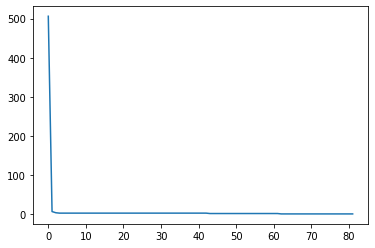

In [28]:
describe_components(investor_graph)

コンポーネント数: 82
ノード数に対するコンポーネント数の割合: 16.37%
投資家コンポーネント上位10件のサイズ
[417   3   2   1   1   1   1   1   1   1]
ネットワーク密度: 4.16%


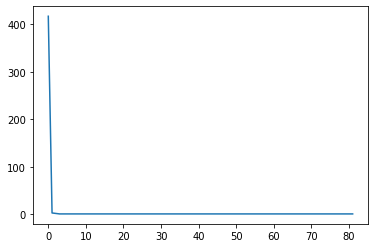

In [29]:
describe_components(company_graph)

# 基本情報の出力
国ごとのバリュエーション、Industryごとのバリュエーションを出力

In [30]:
df.sort_values(by=["Date Joined"])

,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
255,LinkSure Network,$1,1/1/2015,China,Mobile & telecommunications,[N/A],1.00,2015-01-01
242,Kuaishou,$18,1/1/2015,China,Mobile & telecommunications,"[Morningside Venture Capital, Sequoia Capital...",18.00,2015-01-01
244,L&P Cosmetic,$1.19,1/1/2016,South Korea,Consumer & retail,[CDIB Capital],1.19,2016-01-01
418,Traveloka,$3,1/1/2017,Indonesia,Travel,"[Global Founders Capital, East Ventures, Exp...",3.00,2017-01-01
24,AppLovin,$2,1/1/2017,United States,Mobile & telecommunications,"[Orient Hontai Capital, Webb Investment Network]",2.00,2017-01-01
...,...,...,...,...,...,...,...,...
275,Mia.com,$1,9/8/2015,China,E-commerce & direct-to-consumer,"[Sequoia Capital China, ZhenFund, K2 Ventures]",1.00,2015-09-08
302,OfferUp,$1.20,9/8/2016,United States,Mobile & telecommunications,"[Andreessen Horowitz, GGV Capital, T. Rowe P...",1.20,2016-09-08
280,Mollie,$1,9/8/2020,Netherlands,Fintech,[Technology Crossover Ventures],1.00,2020-09-08
460,WEMAKEPRICE,$2.34,9/9/2015,South Korea,E-commerce & direct-to-consumer,"[IMM Investment, NXC]",2.34,2015-09-09


In [31]:
stat_ind = ["mean", "sum", "min", "max", "count"]

In [32]:
country_group = df.groupby("Country").agg(stat_ind)
country_group.head()
cg_df = pd.DataFrame(country_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=country_group.index)
cg_df.sort_values(by=["sum"], ascending=False, inplace=True)
cg_df.head()

,mean,sum,min,max,count
Country,,,,,
United States,2.954321,717.90,1.0,46.00,243.0
China,4.379661,516.80,1.0,140.00,118.0
India,3.510400,87.76,1.0,16.00,25.0
United Kingdom,2.728750,65.49,1.0,11.08,24.0
South Korea,2.761818,30.38,1.0,9.00,11.0


In [33]:
industry_group = df.groupby("Industry").agg(stat_ind)
industry_group.head()
ig_df = pd.DataFrame(industry_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=industry_group.index)
ig_df.sort_values(by=["sum"], ascending=False, inplace=True)
ig_df.head()

,mean,sum,min,max,count
Industry,,,,,
Fintech,3.513099,249.43,1.0,36.0,71.0
Artificial intelligence,5.386444,242.39,1.0,140.0,45.0
E-commerce & direct-to-consumer,2.683594,171.75,1.0,15.0,64.0
Auto & transportation,4.915357,137.63,1.0,62.0,28.0
Internet software & services,2.047656,131.05,1.0,6.0,64.0


In [34]:
y = cg_df["mean"].values
x = cg_df.index.to_numpy()

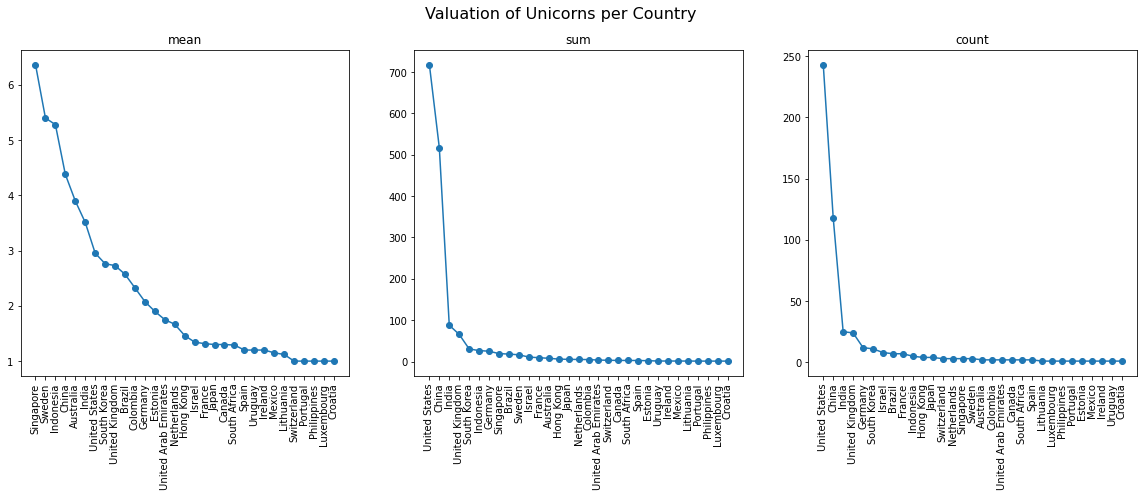

Complete output to ../out/features/value_per_country.png


In [35]:
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Country", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    cg_df.sort_values(by=[col], ascending=False, inplace=True)
    y = cg_df[col].values
    x = cg_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join("..", "out", "features", "value_per_country.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

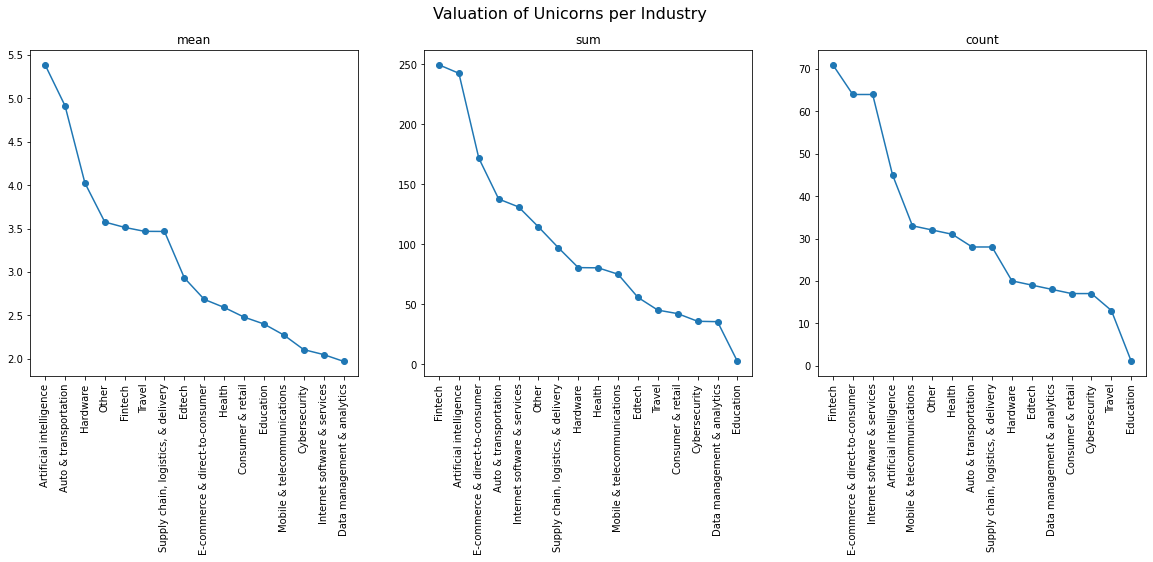

Complete output to ../out/features/value_per_industry.png


In [36]:
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Industry", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    ig_df.sort_values(by=[col], ascending=False, inplace=True)
    y = ig_df[col].values
    x = ig_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join("..", "out", "features", "value_per_industry.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

# 時系列可視化

In [37]:
print(len(df))
tdf = df.set_index("DateTime Joined")
tdf

501


,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot
DateTime Joined,,,,,,,
2018-04-18,100credit,$1,4/18/2018,China,Fintech,"[Sequoia Capital China, China Reform Fund, H...",1.00
2018-03-07,17zuoye,$1,3/7/2018,China,Edtech,"[DST Global, Temasek Holdings]",1.00
2015-07-03,23andMe,$2.50,7/3/2015,United States,Health,"[Google Ventures, New Enterprise Associates, ...",2.50
2018-12-19,4Paradigm,$2,12/19/2018,China,Artificial intelligence,"[Sequoia Capital China, China Construction Ba...",2.00
2015-10-12,58 Daojia,$1,10/12/2015,China,Internet software & services,"[KKR, Alibaba Group, Ping An Insurance]",1.00
...,...,...,...,...,...,...,...
2015-04-10,Zomato,$3.60,4/10/2015,India,Internet software & services,"[Sequoia Capital, VY Capital]",3.60
2018-11-01,Zume,$2.25,11/1/2018,United States,Consumer & retail,"[Softbank Group, AME Cloud Ventures, SignalF...",2.25
2018-07-18,Zuoyebang,$2,7/18/2018,China,Edtech,"[Sequoia Capital China, Xiang He Capital, GG...",2.00


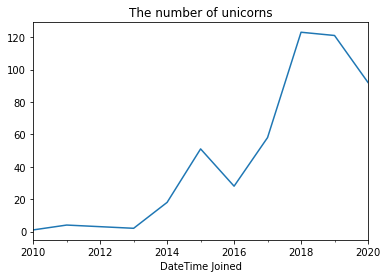

In [38]:
gdf = df.groupby(pd.Grouper(key="DateTime Joined", freq="Y")).agg("count")
gdf = gdf.reset_index().set_index("DateTime Joined")
gdf["Company"].plot(title="The number of unicorns")
plt.savefig(os.path.join("..", "out", "features", "n_unicorns_time_change.png"))

# ネットワークに時系列の要素を追加
カンパニーグラフは知識の流れを表していると解釈することができる。Date Joinedが遅い企業は、早い企業から知識を共有されていると考える。
そうした場合にどこの企業からどこの企業にVCを介して知識が伝播しているかを可視化する。

## ユニコーンネットワーク

In [39]:
company_graph_pd

,source,target
0,Payoneer,Mirakl
1,Payoneer,Marqeta
2,Payoneer,Wacai
3,Payoneer,Via Transportation
4,Payoneer,Celonis
...,...,...
3605,Doctolib,Netskope
3606,Affirm,Apeel Sciences
3607,Netskope,Udaan
3608,Grammarly,Deliveroo


In [40]:
uc_date = df[["Company", "Date Joined", "Country", "Industry", "Valuation($B) flaot"]]
datetime_s = uc_date["Date Joined"].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
uc_date["DateTime Joined"] = datetime_s
uc_date = uc_date.set_index("Company")
elem_dict = uc_date.to_dict("index")

/Users/tokudo/Develop/grips/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
uc_date.head()

,Date Joined,Country,Industry,Valuation($B) flaot,DateTime Joined
Company,,,,,
100credit,4/18/2018,China,Fintech,1.0,2018-04-18
17zuoye,3/7/2018,China,Edtech,1.0,2018-03-07
23andMe,7/3/2015,United States,Health,2.5,2015-07-03
4Paradigm,12/19/2018,China,Artificial intelligence,2.0,2018-12-19
58 Daojia,10/12/2015,China,Internet software & services,1.0,2015-10-12


In [42]:
sources = []
targets = []
for source, target in company_graph_pd.values:
        if elem_dict[source]["DateTime Joined"] > elem_dict[target]["DateTime Joined"]:
            sources.append(target)
            targets.append(source)
        else:
            sources.append(source)
            targets.append(target)
comp_dgraph_df = pd.DataFrame({
    "source": sources,
    "target": targets
})
comp_dgraph_df

,source,target
0,Payoneer,Mirakl
1,Payoneer,Marqeta
2,Payoneer,Wacai
3,Payoneer,Via Transportation
4,Payoneer,Celonis
...,...,...
3605,Netskope,Doctolib
3606,Affirm,Apeel Sciences
3607,Udaan,Netskope
3608,Deliveroo,Grammarly


In [43]:
# チェック用
print(elem_dict["Flexport"]["Date Joined"])
print(elem_dict["Knotel"]["Date Joined"])
print(elem_dict["Gong"]["Date Joined"])
print(elem_dict["VAST Data"]["Date Joined"])
print(elem_dict["Dave"]["Date Joined"])
print(elem_dict["Udemy"]["Date Joined"])

4/30/2018
8/21/2019
8/12/2020
4/16/2020
9/30/2019
2/19/2020


In [44]:
comp_dgraph = nx.from_pandas_edgelist(comp_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [45]:
# 国・産業ごとにノードに色付けのためのCMAP生成
cmap = plt.get_cmap("tab20b")
country_l = df["Country"].unique()
industry_l = df["Industry"].unique()
country_cmap = []
industry_cmap = []
val_size = []
max_val = df["Valuation($B) flaot"].max()
min_val = df["Valuation($B) flaot"].min()
diff = max_val - min_val
for n in comp_dgraph.nodes():
    industry = elem_dict[n]["Industry"]
    ind_idx = np.where(industry_l == industry)
    country = elem_dict[n]["Country"]
    cou_idx = np.where(country_l == country)
    industry_cmap.append(cmap(ind_idx))
    country_cmap.append(cmap(cou_idx))
    val_size.append(
        100 + (elem_dict[n]["Valuation($B) flaot"] - min_val)/diff*900
    )

In [46]:
country_cmap = list(map(lambda x: tuple(x[0][0]), country_cmap))
industry_cmap = list(map(lambda x: tuple(x[0][0]), industry_cmap))

In [47]:
val_size[:10]

[100.0,
 103.23741007194245,
 121.36690647482014,
 100.0,
 108.09352517985612,
 109.71223021582733,
 100.0,
 108.41726618705036,
 100.0,
 104.53237410071942]

In [48]:
# plt.figure(figsize=(100, 100))
# nx.draw_circular(comp_dgraph, font_size=8, node_size=val_size, node_color=country_cmap)
# plt.savefig(os.path.join("..", "out", "sen2jun_dgraph"))

In [49]:
comp_dgraph_centrality_df = get_centrality(comp_dgraph)
comp_dgraph_centrality_df = comp_dgraph_centrality_df.reset_index().rename({"index": "Company"}, axis=1)
comp_dgraph_centrality_df.head()
comp_dgraph_centrality_df = pd.merge(comp_dgraph_centrality_df, df, on="Company", how="left")

In [50]:
comp_dgraph_centrality_df.to_csv(os.path.join("..", "out", "features", "directed_unicorn_centrality.csv"))

## VCネットワーク

In [51]:
investor_graph_pd

,source,target
0,Sands Capital,Revolution Growth
1,Sands Capital,Greycroft
2,Charter Venture Capital,New Leaf Venture Partners
3,Charter Venture Capital,New Enterprise Associates
4,Helion Venture Partners,Bessemer Venture Partners
...,...,...
1235,DST Global,index Ventures
1236,North Bridge Growth Equity,ES Ventures
1237,ICONIQ Capital,Battery Ventures
1238,Aviation Industry Corporation of China,Jiangsu Sha Steel Group


In [52]:
datetime_df = analysis_invest_df[["Investor", "Oldest datetime joined"]]
datetime_df.columns = ["investor", "datetime"]
elem_dict = datetime_df.set_index("investor").to_dict("index")

In [53]:
sources = []
targets = []
for source, target in investor_graph_pd.values:
        if elem_dict[source]["datetime"] > elem_dict[target]["datetime"]:
            sources.append(target)
            targets.append(source)
        else:
            sources.append(source)
            targets.append(target)
investor_dgraph_df = pd.DataFrame({
    "source": sources,
    "target": targets
})
investor_dgraph_df

,source,target
0,Sands Capital,Revolution Growth
1,Greycroft,Sands Capital
2,Charter Venture Capital,New Leaf Venture Partners
3,Charter Venture Capital,New Enterprise Associates
4,Bessemer Venture Partners,Helion Venture Partners
...,...,...
1235,DST Global,index Ventures
1236,North Bridge Growth Equity,ES Ventures
1237,Battery Ventures,ICONIQ Capital
1238,Aviation Industry Corporation of China,Jiangsu Sha Steel Group


In [54]:
investor_dgraph = nx.from_pandas_edgelist(investor_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [55]:
investor_dgraph_centrality_df = get_centrality(investor_dgraph)
investor_dgraph_centrality_df = investor_dgraph_centrality_df.reset_index().rename({"index": "Investor"}, axis=1)
investor_dgraph_centrality_df = pd.merge(investor_dgraph_centrality_df, analysis_invest_df, on="Investor", how="left")
investor_dgraph_centrality_df.to_csv(os.path.join("..", "out", "features", "directed_investor_centrality.csv"))
investor_dgraph_centrality_df.head()

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,...,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,Sands Capital,0.002967,0.0,1.625820e-42,0.001484,0.000995,0.001484,0.001484,1,1,...,3.30,1,3.30,1,{United States},1,{Mobile & telecommunications},1,{Scopely},2019-10-29
1,Revolution Growth,0.002967,0.0,3.674353e-40,0.002967,0.001841,0.002967,0.000000,0,0,...,3.30,1,3.30,1,{United States},1,{Mobile & telecommunications},1,{Scopely},2019-10-29
2,Greycroft,0.008902,0.0,3.604922e-45,0.000000,0.000872,0.000000,0.008902,1,6,...,5.43,3,1.81,2,"{United States, Germany}",3,"{Fintech, Artificial intelligence, Mobile & te...",3,"{Scopely, Deposit Solutions, Icertis}",2019-07-17
3,Charter Venture Capital,0.002967,0.0,3.604922e-45,0.000000,0.000872,0.000000,0.002967,9,357,...,3.80,1,3.80,1,{United States},1,{Health},1,{Intarcia Therapeutics},2014-04-01
4,New Leaf Venture Partners,0.002967,0.0,1.625820e-42,0.001484,0.001242,0.001484,0.001484,9,356,...,3.80,1,3.80,1,{United States},1,{Health},1,{Intarcia Therapeutics},2014-04-01


In [56]:
investor_dgraph_centrality_df.columns

Index(['Investor', 'Degree Centrality', 'Betweenness Centrality',
       'Eigen Centrality', 'Closeness Centrality', 'Page Rank',
       'In-degree Centrality', 'Out-degree Centrality', 'Elongation',
       'Expansion', 'Teacher Disciple Degree', 'Colleague Degree',
       'Unidirect Density', 'Bidirect Density', 'Total valuation($B)',
       'Valuation count', 'Mean valuation($B)', '#countries', 'Country set',
       '#industries', 'Industry set', '#unicorns', 'Unicorn set',
       'Oldest datetime joined'],
      dtype='object')

In [57]:
investor_data_df = investor_dgraph_centrality_df.drop(['Country set','Industry set', 'Unicorn set','Oldest datetime joined'], axis=1)
investor_data_df.corr()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
Degree Centrality,1.000000,0.821445,-0.020511,0.210431,0.162974,0.653687,0.957560,0.576697,0.553174,NaN,NaN,1.000000,NaN,0.710327,0.989324,0.055185,0.762981,0.954295,0.989324
Betweenness Centrality,0.821445,1.000000,-0.015217,0.205115,0.228986,0.610442,0.758598,0.460670,0.426529,NaN,NaN,0.821445,NaN,0.618156,0.817084,0.031621,0.575688,0.734472,0.817084
Eigen Centrality,-0.020511,-0.015217,1.000000,0.089442,0.184865,0.006969,-0.027402,-0.039216,-0.021129,NaN,NaN,-0.020511,NaN,-0.018092,-0.021009,-0.012199,-0.019610,-0.023969,-0.021009
Closeness Centrality,0.210431,0.205115,0.089442,1.000000,0.288735,0.566624,0.038078,-0.101325,-0.149522,NaN,NaN,0.210431,NaN,0.069805,0.185785,-0.002873,0.167180,0.183052,0.185785
Page Rank,0.162974,0.228986,0.184865,0.288735,1.000000,0.510347,0.002254,-0.171715,-0.078490,NaN,NaN,0.162974,NaN,0.080559,0.142699,-0.007666,0.078447,0.112592,0.142699
In-degree Centrality,0.653687,0.610442,0.006969,0.566624,0.510347,1.000000,0.407819,0.189299,0.111766,NaN,NaN,0.653687,NaN,0.387875,0.626177,0.063770,0.494905,0.598468,0.626177
Out-degree Centrality,0.957560,0.758598,-0.027402,0.038078,0.002254,0.407819,1.000000,0.623706,0.624854,NaN,NaN,0.957560,NaN,0.709301,0.955157,0.042294,0.732064,0.923446,0.955157
Elongation,0.576697,0.460670,-0.039216,-0.101325,-0.171715,0.189299,0.623706,1.000000,0.834525,NaN,NaN,0.576697,NaN,0.421524,0.570601,0.085384,0.469468,0.611989,0.570601
Expansion,0.553174,0.426529,-0.021129,-0.149522,-0.078490,0.111766,0.624854,0.834525,1.000000,NaN,NaN,0.553174,NaN,0.491626,0.553459,0.129910,0.405669,0.577035,0.553459
Teacher Disciple Degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


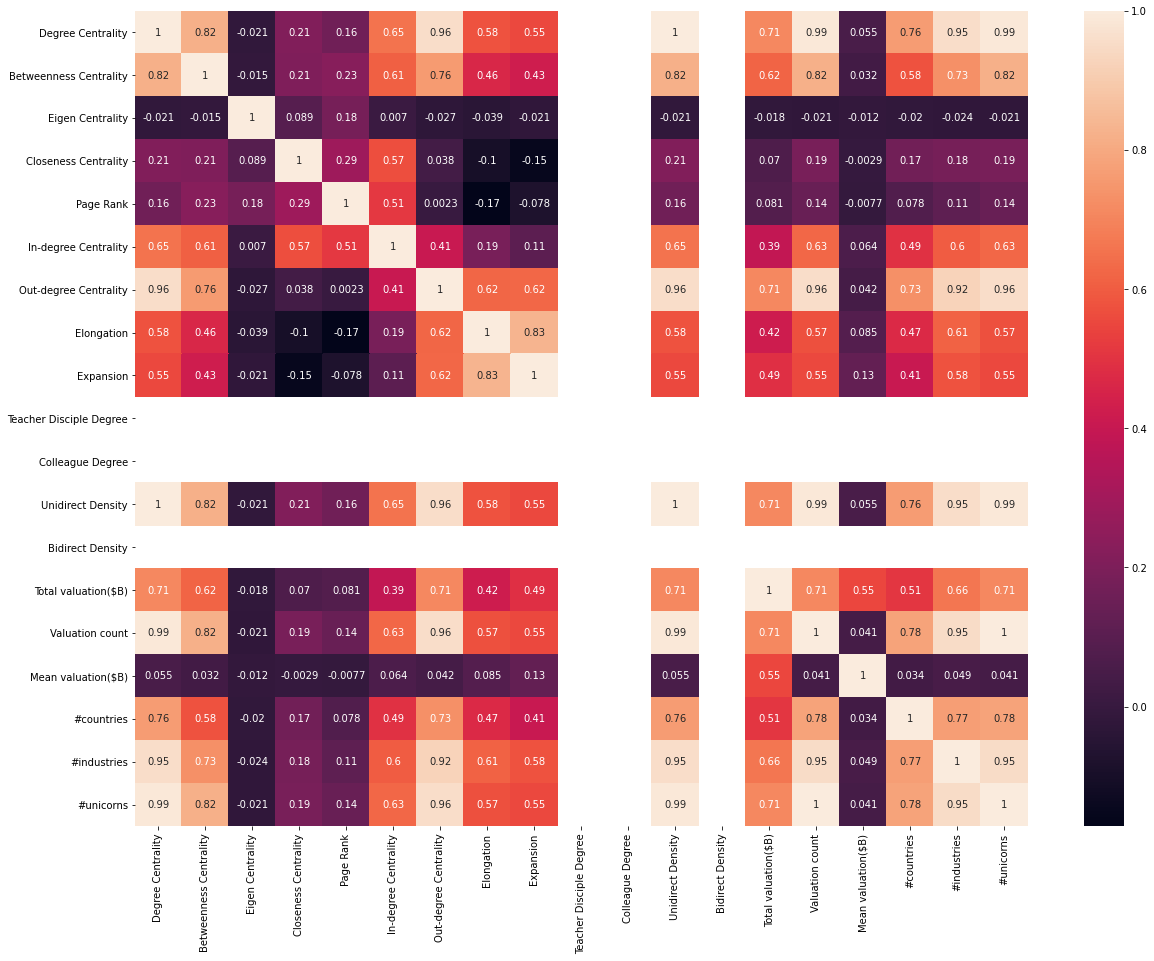

In [58]:
plt.figure(figsize=(20, 15))
sns.heatmap(investor_data_df.corr(), annot=True)
plt.savefig(os.path.join("..", "out", "features", "investor_correlation.png"))

In [59]:
value_df = df[["Company", "Valuation($B) flaot"]]
value_df.head()

,Company,Valuation($B) flaot
0,100credit,1.0
1,17zuoye,1.0
2,23andMe,2.5
3,4Paradigm,2.0
4,58 Daojia,1.0


In [60]:
unicorn_data_df = pd.merge(comp_dgraph_centrality_df, value_df, on="Company", how="left").set_index("Company")

In [61]:
unicorn_data_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,...,Unidirect Density,Bidirect Density,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot_x,DateTime Joined,Valuation($B) flaot_y
Company,,,,,,,,,,,,,,,,,,,,,
Payoneer,0.014252,0.000000,2.250254e-59,0.000000,0.000816,0.000000,0.014252,9,129,1.0,...,0.007109,0.0,$1,12/5/2017,United States,Fintech,"[Susquehanna Growth Equity, 83North, China B...",1.00,2017-12-05,1.00
Mirakl,0.009501,0.000000,1.672867e-08,0.081035,0.002987,0.009501,0.000000,0,0,1.0,...,0.004739,0.0,$1.50,9/22/2020,France,E-commerce & direct-to-consumer,"[Elaia Partners, 83North, Felix Capital]",1.50,2020-09-22,1.50
Marqeta,0.009501,0.000000,6.296718e-29,0.050908,0.000985,0.004751,0.004751,3,4,1.0,...,0.004739,0.0,$4.30,5/21/2019,United States,Fintech,"[83North, Granite Ventures, CommerzVentures]",4.30,2019-05-21,4.30
Wacai,0.021378,0.001135,6.955311e-29,0.051612,0.001162,0.011876,0.009501,6,68,1.0,...,0.010664,0.0,$1,7/18/2018,China,Mobile & telecommunications,"[Qiming Venture Partners, China Broadband Cap...",1.00,2018-07-18,1.00
Via Transportation,0.019002,0.001824,1.746819e-09,0.087438,0.003726,0.014252,0.004751,2,3,1.0,...,0.009479,0.0,$2.25,3/30/2020,United States,Auto & transportation,"[83North, RiverPark Ventures, Pitango Ventur...",2.25,2020-03-30,2.25


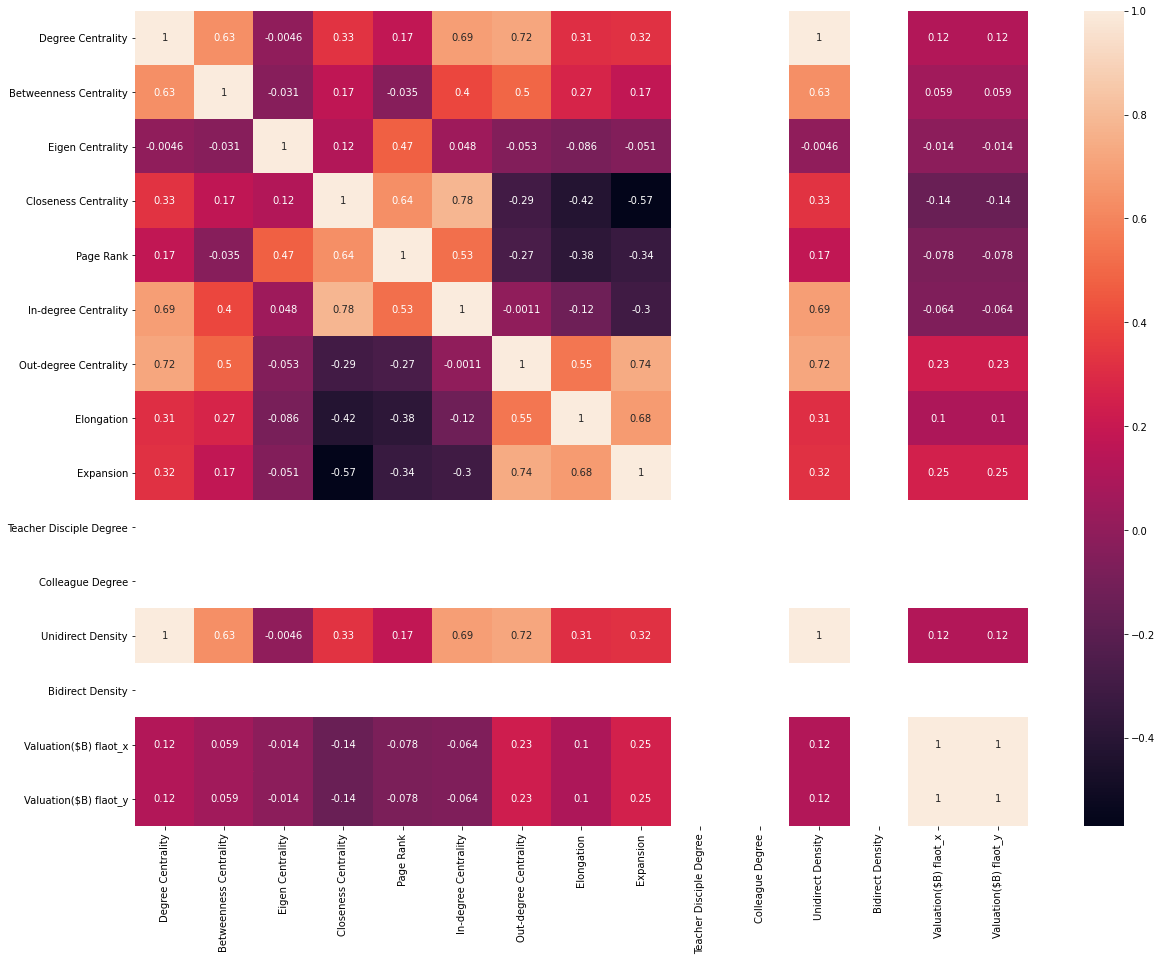

In [62]:
plt.figure(figsize=(20, 15))
sns.heatmap(unicorn_data_df.corr(), annot=True)
plt.savefig(os.path.join("..", "out", "features", "unicorn_correlation.png"))

valuationとユニコーン有向ネットワークの中心性との間に相関は見られない。

* 国ごと産業ごとの比較。
* 名寄せの問題。これは細かいので後回し
* 仮説を立てる。
  * VCのネットワークの意味は？
    * 何の関係を表してる？情報の流れ？
  * ユニコーンのネットワークの意味は？
    * 情報の流れ

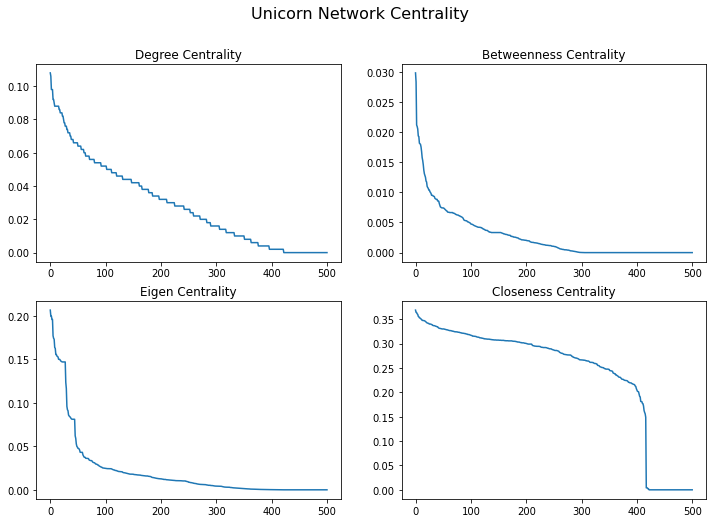

In [63]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Unicorn Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join("..", "out", "features", "unicorn_network_centrality.png"))

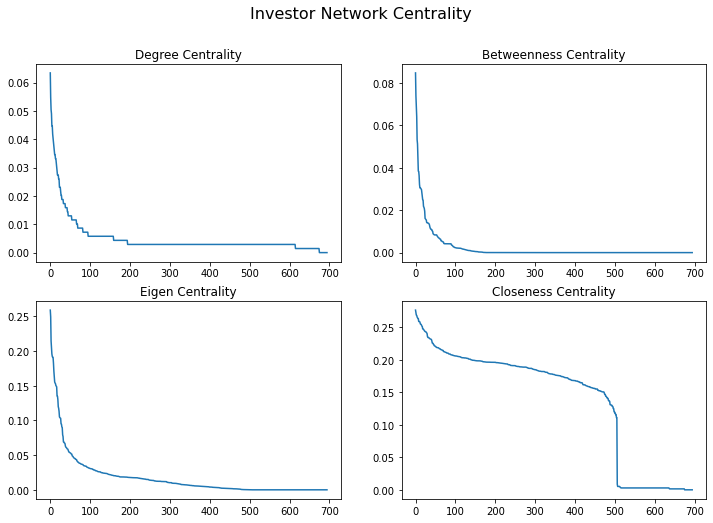

In [64]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Investor Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join("..", "out", "features", "investor_network_centrality.png"))

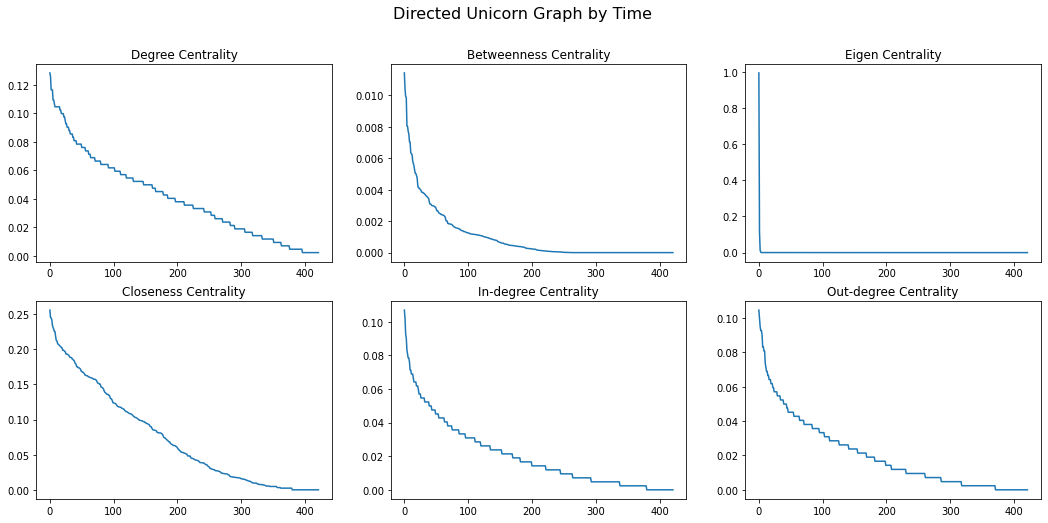

In [65]:
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Directed Unicorn Graph by Time", fontsize=16)
ax1 = fig.add_subplot(231)
col = "Degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(232)
col = "Betweenness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(233)
col = "Eigen Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(234)
col = "Closeness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
ax5 = fig.add_subplot(235)
col = "In-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax5.set_title(col)
ax5.plot(x, y)
ax6 = fig.add_subplot(236)
col = "Out-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax6.set_title(col)
ax6.plot(x, y)
plt.savefig(os.path.join("..", "out", "features", "directed_unicorn_centrality.png"))

# データの出力

In [66]:
investor_centrality_df.to_csv(os.path.join("..", "out", "features", "investor_centrality.csv"))
company_centrality_df.to_csv(os.path.join("..", "out", "features", "unicorn_centrality.csv"))

In [67]:
unicorn_data_df.corr().to_csv(os.path.join("..", "out", "features", "unicorn_correlation.csv"))
investor_data_df.corr().to_csv(os.path.join("..", "out", "features", "investor_correlation.csv"))

## 企業 - 国・産業ネットワーク

In [68]:
df

,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
0,100credit,$1,4/18/2018,China,Fintech,"[Sequoia Capital China, China Reform Fund, H...",1.00,2018-04-18
1,17zuoye,$1,3/7/2018,China,Edtech,"[DST Global, Temasek Holdings]",1.00,2018-03-07
2,23andMe,$2.50,7/3/2015,United States,Health,"[Google Ventures, New Enterprise Associates, ...",2.50,2015-07-03
3,4Paradigm,$2,12/19/2018,China,Artificial intelligence,"[Sequoia Capital China, China Construction Ba...",2.00,2018-12-19
4,58 Daojia,$1,10/12/2015,China,Internet software & services,"[KKR, Alibaba Group, Ping An Insurance]",1.00,2015-10-12
...,...,...,...,...,...,...,...,...
496,Zomato,$3.60,4/10/2015,India,Internet software & services,"[Sequoia Capital, VY Capital]",3.60,2015-04-10
497,Zume,$2.25,11/1/2018,United States,Consumer & retail,"[Softbank Group, AME Cloud Ventures, SignalF...",2.25,2018-11-01
498,Zuoyebang,$2,7/18/2018,China,Edtech,"[Sequoia Capital China, Xiang He Capital, GG...",2.00,2018-07-18
499,Zwift,$1,9/16/2020,United States,E-commerce & direct-to-consumer,"[Novator Partners, True, Causeway Media Part...",1.00,2020-09-16


In [100]:
country_industry_df = pd.merge(comp_dgraph_df, df[["Company", "Country", "Industry", "DateTime Joined"]], left_on="source", right_on="Company", how="left")
country_industry_df = pd.merge(country_industry_df, df[["Company", "Country", "Industry", "DateTime Joined"]], left_on="target", right_on="Company", how="left", suffixes=["_source", "_target"])
country_industry_df = country_industry_df.drop(["Company_source", "Company_target"], axis=1)
country_industry_df.head()
country_industry_df.to_csv(os.path.join("..", "out", "edgelist", "country_industry_dgraph.csv"))

In [70]:
country_dgraph_df = country_industry_df.groupby(by=["Country_source", "Country_target"], as_index=False).agg({'source': 'count'})
country_dgraph_df.columns = ["source", "target", "weight"]
country_G = nx.from_pandas_edgelist(
    country_dgraph_df, create_using=nx.Graph, edge_attr=["weight"]
)
country_graph_df = nx.to_pandas_edgelist(country_G)
country_graph_df.to_csv(os.path.join("..", "out", "edgelist", "country_graph.csv"))
country_graph_matrix = nx.to_pandas_adjacency(country_G)
country_graph_matrix.to_csv(os.path.join("..", "out", "adjacency", "country_graph.csv"))

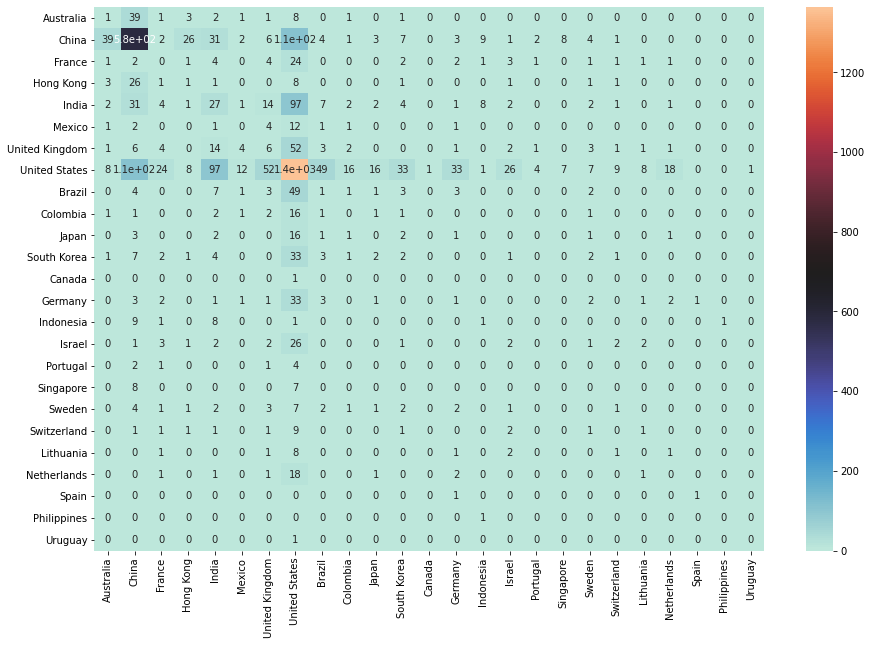

In [71]:
plt.figure(figsize=(15, 10))
sns.heatmap(country_graph_matrix, center=700, annot=True)
plt.savefig(os.path.join("..", "out", "adjacency", "country_graph.png"))

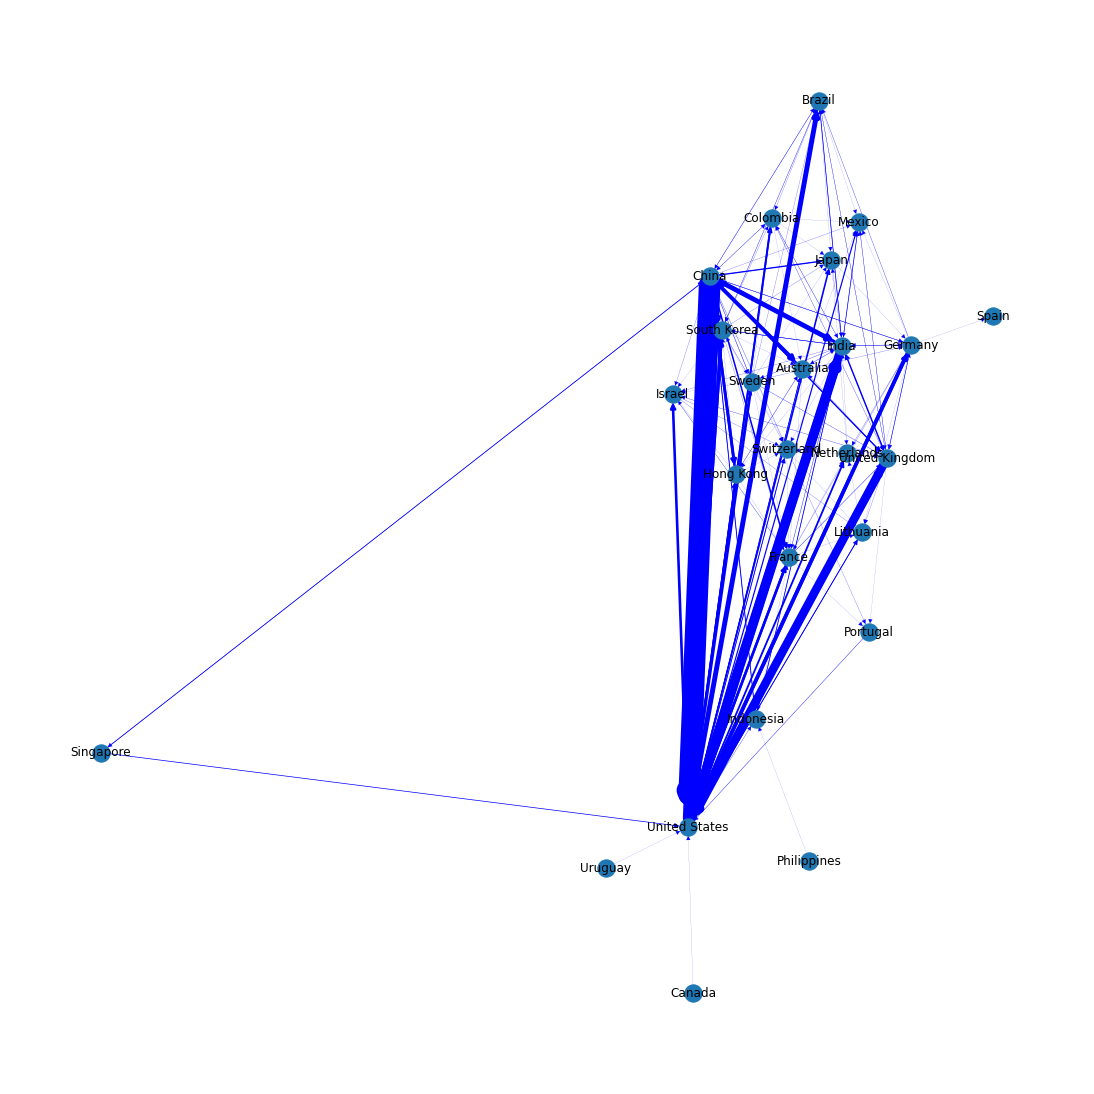

In [72]:
country_DG = nx.from_pandas_edgelist(
    country_dgraph_df, create_using=nx.DiGraph, edge_attr=["weight"]
)
edge_widths = [d['weight']/10 for _,_,d in country_DG.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    country_DG, width=edge_widths,
    pos=nx.kamada_kawai_layout(country_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join("..", "out", "edgelist", "country_dgraph.png"))
country_dgraph_df.to_csv(os.path.join("..", "out", "edgelist", "country_dgraph.csv"))

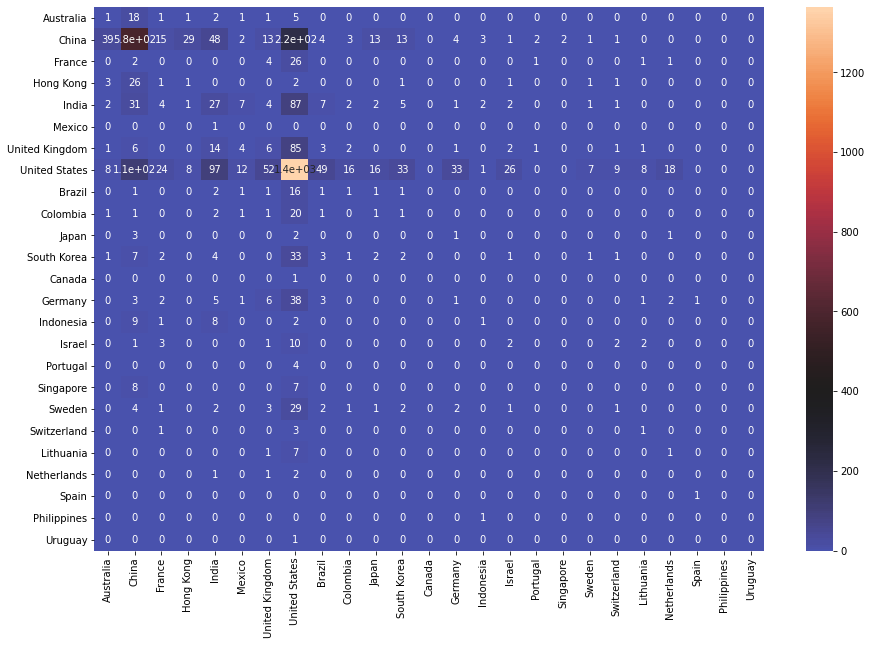

In [73]:
country_dgraph_matrix = nx.to_pandas_adjacency(country_DG)
plt.figure(figsize=(15, 10))
sns.heatmap(country_dgraph_matrix, center=400, annot=True)
plt.savefig(os.path.join("..", "out", "adjacency", "country_dgraph.png"))
country_dgraph_matrix.to_csv(os.path.join("..", "out", "adjacency", "country_dgraph.csv"))

In [74]:
industry_dgraph_df = country_industry_df.groupby(by=["Industry_source", "Industry_target"], as_index=False).agg({"source": 'count'})
industry_dgraph_df.columns = ["source", "target", "weight"]
industry_G = nx.from_pandas_edgelist(industry_dgraph_df, create_using=nx.Graph, edge_attr="weight")
industry_graph_df = nx.to_pandas_edgelist(industry_G)
industry_graph_df.to_csv(os.path.join("..", "out", "edgelist", "industry_graph.csv"))
industry_graph_matrix = nx.to_pandas_adjacency(industry_G)
industry_graph_matrix.to_csv(os.path.join("..", "out", "adjacency", "industry_graph.csv"))
industry_graph_df.head()

,source,target,weight
0,Artificial intelligence,Artificial intelligence,20
1,Artificial intelligence,Auto & transportation,12
2,Artificial intelligence,Consumer & retail,7
3,Artificial intelligence,Cybersecurity,6
4,Artificial intelligence,Data management & analytics,16


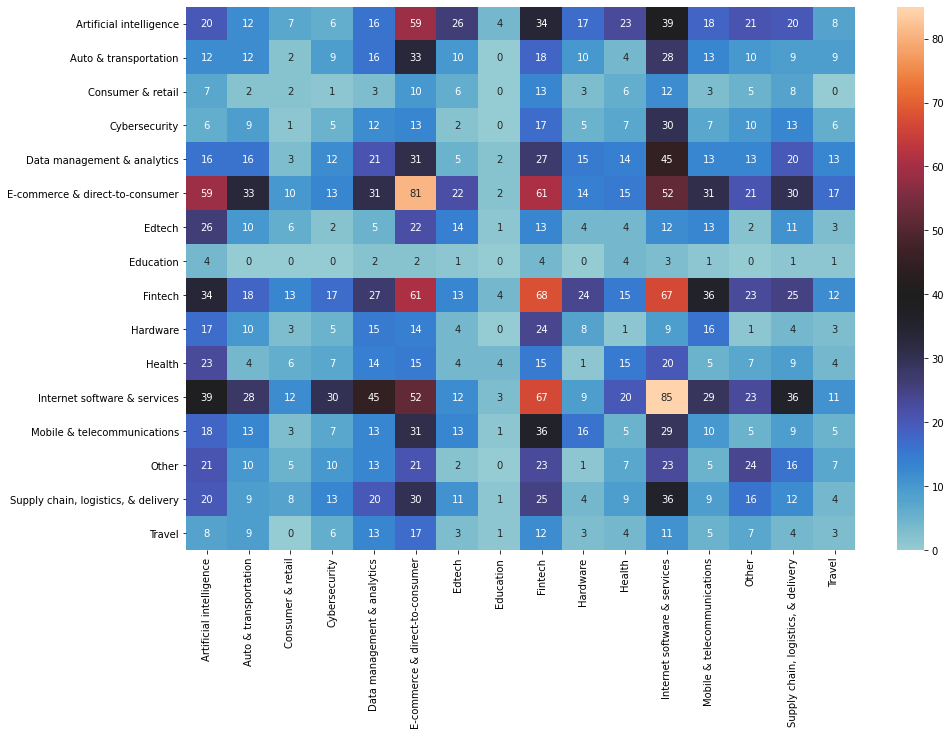

In [75]:
plt.figure(figsize=(15, 10))
sns.heatmap(industry_graph_matrix, center=40, annot=True)
plt.savefig(os.path.join("..", "out", "adjacency", "industry_graph.png"))

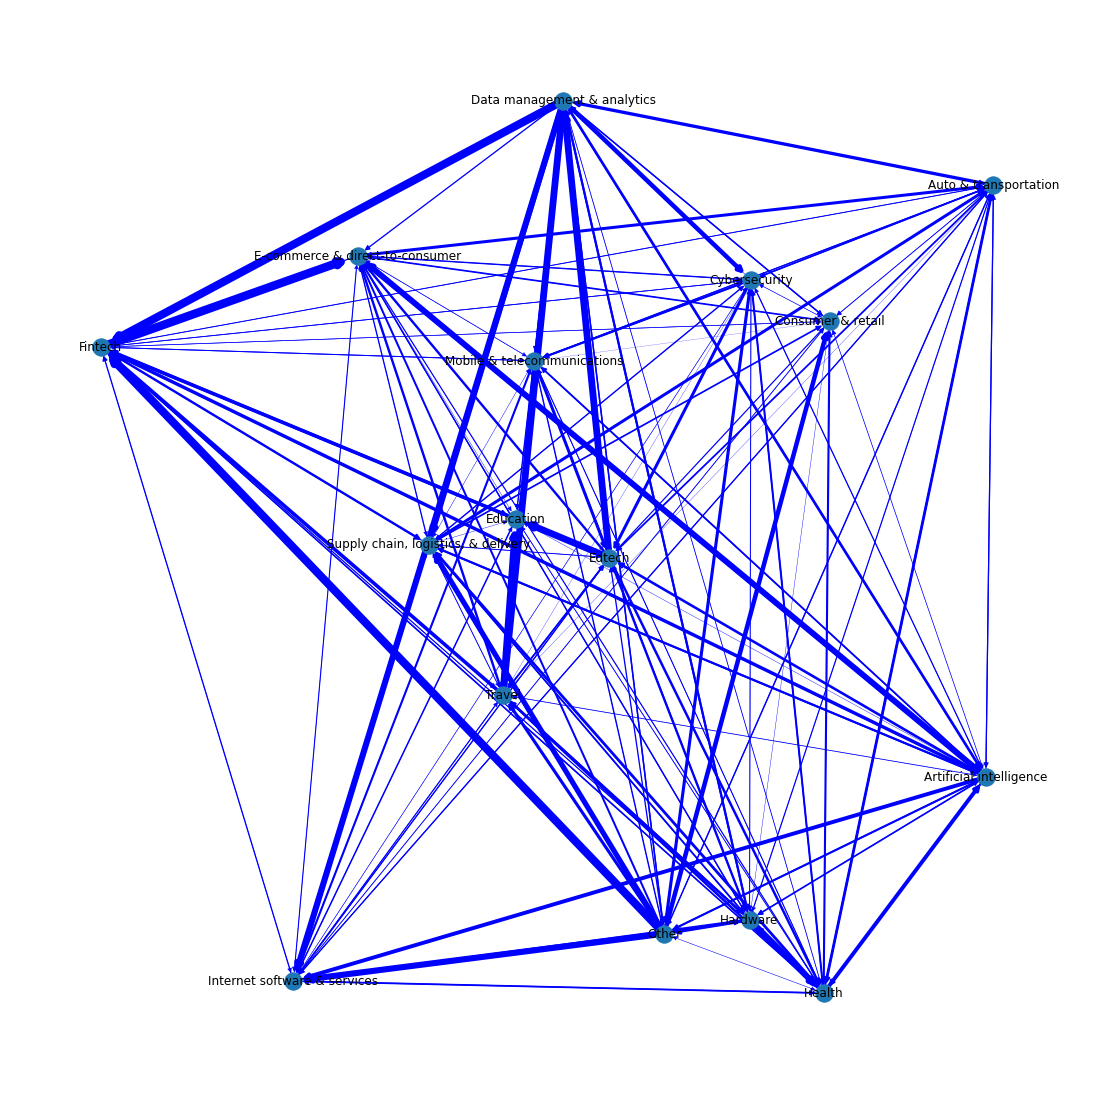

In [76]:
industry_DG = nx.from_pandas_edgelist(industry_dgraph_df, create_using=nx.DiGraph, edge_attr="weight")
edge_width = [v["weight"] * 0.1 for _, _, v in industry_G.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    industry_DG, width=edge_width, pos=nx.kamada_kawai_layout(industry_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join("..", "out", "edgelist", "industry_dgraph.png"))
industry_dgraph_df.to_csv(os.path.join("..", "out", "edgelist", "industry_dgraph.csv"))

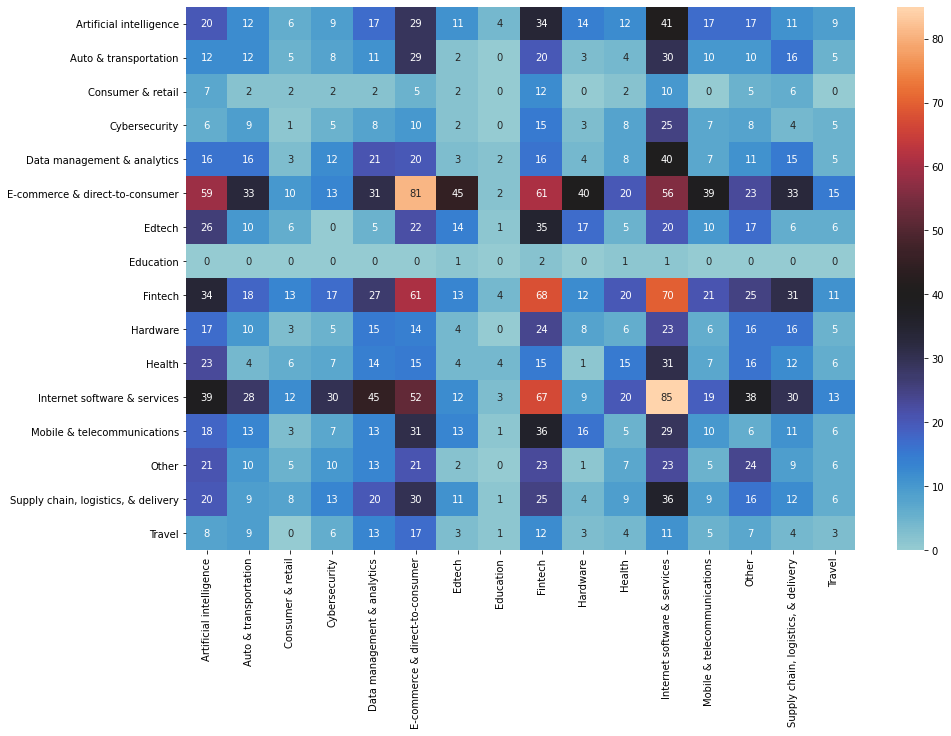

In [77]:
industry_dgraph_matrix = nx.to_pandas_adjacency(industry_DG)
plt.figure(figsize=(15, 10))
sns.heatmap(industry_dgraph_matrix, center=40, annot=True)
plt.savefig(os.path.join("..", "out", "adjacency", "industry_dgraph.png"))
industry_dgraph_matrix.to_csv(os.path.join("..", "out", "adjacency", "industry_dgraph.csv"))

In [78]:
country_centrality_df = get_centrality(country_G)
industry_centrality_df = get_centrality(industry_G)

In [79]:
country_centrality_df.to_csv(os.path.join("..", "out", "features", "country_unicorn_centrality.csv"))

In [80]:
industry_centrality_df.to_csv(os.path.join("..", "out", "features", "industry_unicorn_centrality.csv"))

# 回帰分析

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

## ユニコーン回帰分析

In [82]:
unicorn_data_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,...,Unidirect Density,Bidirect Density,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot_x,DateTime Joined,Valuation($B) flaot_y
Company,,,,,,,,,,,,,,,,,,,,,
Payoneer,0.014252,0.000000,2.250254e-59,0.000000,0.000816,0.000000,0.014252,9,129,1.0,...,0.007109,0.0,$1,12/5/2017,United States,Fintech,"[Susquehanna Growth Equity, 83North, China B...",1.00,2017-12-05,1.00
Mirakl,0.009501,0.000000,1.672867e-08,0.081035,0.002987,0.009501,0.000000,0,0,1.0,...,0.004739,0.0,$1.50,9/22/2020,France,E-commerce & direct-to-consumer,"[Elaia Partners, 83North, Felix Capital]",1.50,2020-09-22,1.50
Marqeta,0.009501,0.000000,6.296718e-29,0.050908,0.000985,0.004751,0.004751,3,4,1.0,...,0.004739,0.0,$4.30,5/21/2019,United States,Fintech,"[83North, Granite Ventures, CommerzVentures]",4.30,2019-05-21,4.30
Wacai,0.021378,0.001135,6.955311e-29,0.051612,0.001162,0.011876,0.009501,6,68,1.0,...,0.010664,0.0,$1,7/18/2018,China,Mobile & telecommunications,"[Qiming Venture Partners, China Broadband Cap...",1.00,2018-07-18,1.00
Via Transportation,0.019002,0.001824,1.746819e-09,0.087438,0.003726,0.014252,0.004751,2,3,1.0,...,0.009479,0.0,$2.25,3/30/2020,United States,Auto & transportation,"[83North, RiverPark Ventures, Pitango Ventur...",2.25,2020-03-30,2.25


In [83]:
unicorn_data_df.columns

Index(['Degree Centrality', 'Betweenness Centrality', 'Eigen Centrality',
       'Closeness Centrality', 'Page Rank', 'In-degree Centrality',
       'Out-degree Centrality', 'Elongation', 'Expansion',
       'Teacher Disciple Degree', 'Colleague Degree', 'Unidirect Density',
       'Bidirect Density', 'Valuation($B)', 'Date Joined', 'Country',
       'Industry', 'Select Investors', 'Valuation($B) flaot_x',
       'DateTime Joined', 'Valuation($B) flaot_y'],
      dtype='object')

In [84]:
train_df = unicorn_data_df.drop([
    'Valuation($B)', 'Date Joined', 'Country', 'Industry', 'Select Investors',
    'DateTime Joined', 'Valuation($B) flaot_y', "Colleague Degree", "Bidirect Density",
    "Teacher Disciple Degree"
], axis=1)
# [
#     'Valuation($B)', 'Date Joined', 'Country', 'Industry', 'Select Investors', 'DateTime Joined', 'Valuation($B) flaot_y', 'Degree Centrality',
#     'Elongation', 'Expansion', 'Unidirect Density', 'Teacher Disciple Degree', 'Colleague Degree', 'Bidirect Density', 'In-degree Centrality',
#     'Page Rank'
# ] -> r2: 0.0615236981958418
d = ["Betweenness Centrality", "Elongation", "Page Rank", "Eigen Centrality",
     "Closeness Centrality", 'In-degree Centrality', "Degree Centrality", "Unidirect Density"]
train_df.drop(d, axis=1, inplace=True)
train_df.head()

,Out-degree Centrality,Expansion,Valuation($B) flaot_x
Company,,,
Payoneer,0.014252,129,1.00
Mirakl,0.000000,0,1.50
Marqeta,0.004751,4,4.30
Wacai,0.009501,68,1.00
Via Transportation,0.004751,3,2.25


<AxesSubplot:>

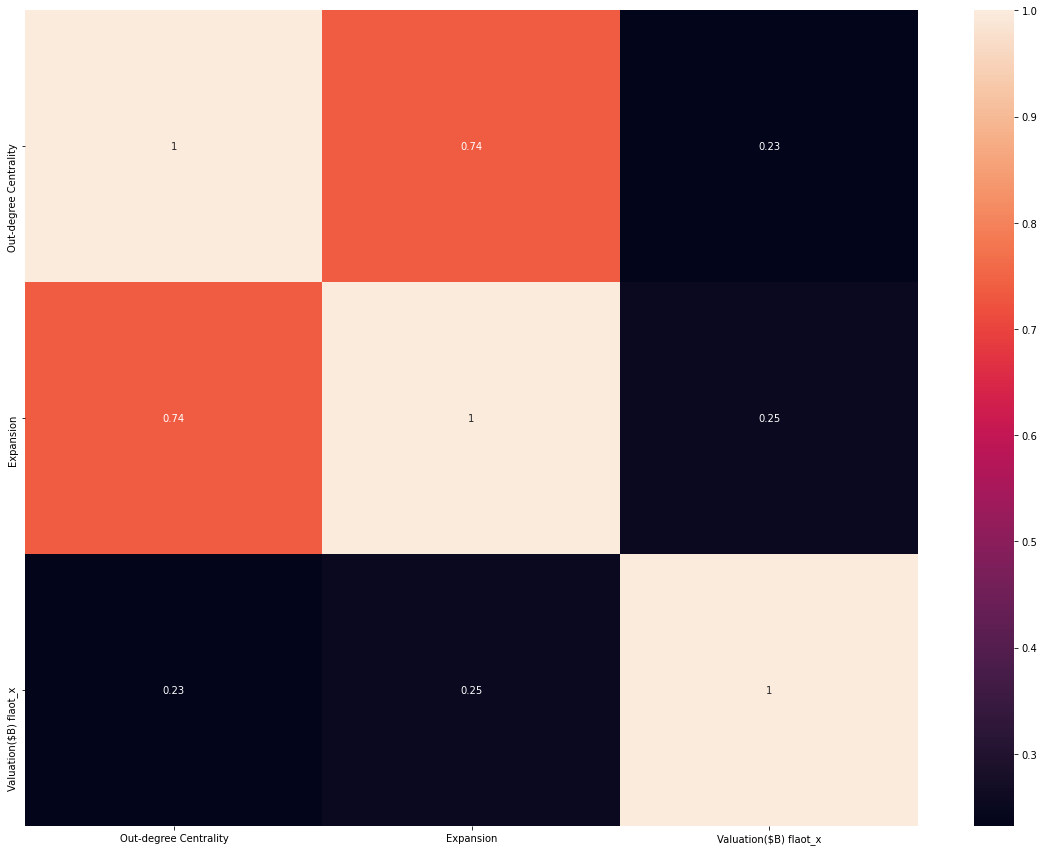

In [85]:
plt.figure(figsize=(20, 15))
sns.heatmap(train_df.corr(), annot=True)

In [86]:
sc = StandardScaler()
data_std = sc.fit_transform(train_df)
x, y = data_std[:,:-1], data_std[:, -1]
y = y.reshape(len(y), 1)
x_df = pd.DataFrame(x, columns=train_df.columns[:-1])
y_df = pd.DataFrame(y, columns=[train_df.columns[-1]])

In [87]:
mod = sm.OLS(y_df, sm.add_constant(x_df))
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Valuation($B) flaot_x   R-squared:                       0.068
Model:                               OLS   Adj. R-squared:                  0.064
Method:                    Least Squares   F-statistic:                     15.29
Date:                   Fri, 23 Apr 2021   Prob (F-statistic):           3.90e-07
Time:                           18:57:34   Log-Likelihood:                -583.93
No. Observations:                    422   AIC:                             1174.
Df Residuals:                        419   BIC:                             1186.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -6.234e-17      0.047  -1.32e-15      1.000      -0.093       0.093
Out-degree Centrality     0.1023      0.070      1.465      0.144      -0.035       0.240
Expansion                 0.1760      0.070      2.521      0.012       0.039       0.313
==============================================================================
Omnibus:                      792.614   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           599058.840
Skew:                          12.002   Prob(JB):                         0.00
Kurtosis:                     186.012   Cond. No.                         2.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
train_df.corr()

,Out-degree Centrality,Expansion,Valuation($B) flaot_x
Out-degree Centrality,1.000000,0.737374,0.23210
Expansion,0.737374,1.000000,0.25147
Valuation($B) flaot_x,0.232100,0.251470,1.00000


In [89]:
np.sign(result.params[1:]) - np.sign(train_df.corr()["Valuation($B) flaot_x"][:-1].values)

Out-degree Centrality    0.0
Expansion                0.0
dtype: float64

In [90]:
with open(os.path.join("..", "out", "features", "unicorn_regression.csv"), "w", encoding="utf-8") as f:
    f.write(result.summary().as_csv())

## VC回帰分析

In [91]:
investor_data_df.head()

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
0,Sands Capital,0.002967,0.0,1.625820e-42,0.001484,0.000995,0.001484,0.001484,1,1,1.0,0.0,0.001481,0.0,3.30,1,3.30,1,1,1
1,Revolution Growth,0.002967,0.0,3.674353e-40,0.002967,0.001841,0.002967,0.000000,0,0,1.0,0.0,0.001481,0.0,3.30,1,3.30,1,1,1
2,Greycroft,0.008902,0.0,3.604922e-45,0.000000,0.000872,0.000000,0.008902,1,6,1.0,0.0,0.004444,0.0,5.43,3,1.81,2,3,3
3,Charter Venture Capital,0.002967,0.0,3.604922e-45,0.000000,0.000872,0.000000,0.002967,9,357,1.0,0.0,0.001481,0.0,3.80,1,3.80,1,1,1
4,New Leaf Venture Partners,0.002967,0.0,1.625820e-42,0.001484,0.001242,0.001484,0.001484,9,356,1.0,0.0,0.001481,0.0,3.80,1,3.80,1,1,1


In [92]:
investor_data_df.describe()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
count,675.000000,675.000000,6.750000e+02,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.0,675.0,675.000000,675.0,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000
mean,0.005451,0.000168,2.436949e-03,0.012894,0.001481,0.002726,0.002726,1.448889,29.454815,1.0,0.0,0.002722,0.0,6.851896,2.022222,2.959295,1.257778,1.644444,2.022222
std,0.007363,0.000674,3.844128e-02,0.011502,0.000594,0.002324,0.006102,2.248305,88.315520,0.0,0.0,0.003676,0.0,18.237397,2.981811,7.060772,0.823565,1.617168,2.981811
min,0.001484,0.000000,3.604922e-45,0.000000,0.000872,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000741,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.002967,0.000000,3.674353e-40,0.002649,0.000998,0.001484,0.000000,0.000000,0.000000,1.0,0.0,0.001481,0.0,1.085000,1.000000,1.037500,1.000000,1.000000,1.000000
50%,0.002967,0.000000,2.737206e-23,0.011151,0.001250,0.002967,0.001484,1.000000,1.000000,1.0,0.0,0.001481,0.0,2.000000,1.000000,1.600000,1.000000,1.000000,1.000000
75%,0.004451,0.000000,3.777391e-11,0.021500,0.001814,0.002967,0.002967,1.000000,2.000000,1.0,0.0,0.002222,0.0,4.450000,2.000000,2.666667,1.000000,2.000000,2.000000
max,0.065282,0.009905,7.237992e-01,0.052591,0.004053,0.017804,0.054896,11.000000,461.000000,1.0,0.0,0.032593,0.0,225.280000,28.000000,140.000000,9.000000,13.000000,28.000000


In [93]:
investor_data_df = investor_data_df.set_index("Investor")

In [94]:
train_df = investor_data_df.drop(["Valuation count", "Mean valuation($B)", "Bidirect Density", "Colleague Degree", "Teacher Disciple Degree"], axis=1)
target = train_df["Total valuation($B)"]
train_df.drop("Total valuation($B)", axis=1, inplace=True)
train_df["Total valuation($B)"] = target
d = [
    "Degree Centrality", 'Closeness Centrality', 'Page Rank', 'Unidirect Density', '#countries', '#industries', "Elongation",
    'Eigen Centrality', 'In-degree Centrality', 'Out-degree Centrality'
]
train_df = train_df.drop(d, axis=1)
train_df.describe()

,Betweenness Centrality,Expansion,#unicorns,Total valuation($B)
count,675.000000,675.000000,675.000000,675.000000
mean,0.000168,29.454815,2.022222,6.851896
std,0.000674,88.315520,2.981811,18.237397
min,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,1.085000
50%,0.000000,1.000000,1.000000,2.000000
75%,0.000000,2.000000,2.000000,4.450000
max,0.009905,461.000000,28.000000,225.280000


In [95]:
sc = StandardScaler()
data_std = sc.fit_transform(train_df)
x, y = data_std[:,:-1], data_std[:, -1]
# y = sc.fit_transform(y)
y = y.reshape(len(y), 1)
x_df = pd.DataFrame(x, columns=train_df.columns[:-1])
y_df = pd.DataFrame(y, columns=[train_df.columns[-1]])

In [96]:
mod = sm.OLS(y_df, sm.add_constant(x_df))
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Total valuation($B)   R-squared:                       0.525
Model:                             OLS   Adj. R-squared:                  0.523
Method:                  Least Squares   F-statistic:                     247.2
Date:                 Fri, 23 Apr 2021   Prob (F-statistic):          5.22e-108
Time:                         18:57:34   Log-Likelihood:                -706.56
No. Observations:                  675   AIC:                             1421.
Df Residuals:                      671   BIC:                             1439.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   7.091e-17      0.027   2.66e-15      1.000      -0.052       0.052
Betweenness Centrality     0.1220      0.046      2.639      0.009       0.031       0.213
Expansion                  0.1456      0.032      4.550      0.000       0.083       0.208
#unicorns                  0.5313      0.050     10.585      0.000       0.433       0.630
==============================================================================
Omnibus:                      945.684   Durbin-Watson:                   1.471
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           188211.115
Skew:                           7.523   Prob(JB):                         0.00
Kurtosis:                      83.409   Cond. No.                         3.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
train_df.columns[:-1]

Index(['Betweenness Centrality', 'Expansion', '#unicorns'], dtype='object')

In [98]:
np.sign(result.params[1:]) - np.sign(train_df.corr()["Total valuation($B)"][:-1].values)

Betweenness Centrality    0.0
Expansion                 0.0
#unicorns                 0.0
dtype: float64

In [99]:
with open(os.path.join("..", "out", "features", "investor_regression.csv"), "w", encoding="utf-8") as f:
    f.write(result.summary().as_csv())